In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [113]:
df=pd.read_csv("../../data/merged/len3_prod_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_12532\3490194615.py:1: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_prod_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [114]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [115]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
# df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
# df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
# df["stock_otc_lag"].fillna(0,inplace=True)
# df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
# df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
# df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
# df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
# df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [116]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2553 entries, (114, 2009) to (799, 2022)
Columns: 639 entries, month to year_trend
dtypes: datetime64[ns](1), float64(11), int32(2), int64(601), object(12), uint8(12)
memory usage: 12.2+ MB


(639, 14, 21)

In [117]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [118]:
before_p=8*12
after_p=10*12
elasped = ''.join(["+elasped_m" + str(i) for i in range(before_p, 0, -1)])
elasped=elasped+''.join(["+elasped_" + str(i) for i in range(0,after_p+1)])
print(elasped)


+elasped_m96+elasped_m95+elasped_m94+elasped_m93+elasped_m92+elasped_m91+elasped_m90+elasped_m89+elasped_m88+elasped_m87+elasped_m86+elasped_m85+elasped_m84+elasped_m83+elasped_m82+elasped_m81+elasped_m80+elasped_m79+elasped_m78+elasped_m77+elasped_m76+elasped_m75+elasped_m74+elasped_m73+elasped_m72+elasped_m71+elasped_m70+elasped_m69+elasped_m68+elasped_m67+elasped_m66+elasped_m65+elasped_m64+elasped_m63+elasped_m62+elasped_m61+elasped_m60+elasped_m59+elasped_m58+elasped_m57+elasped_m56+elasped_m55+elasped_m54+elasped_m53+elasped_m52+elasped_m51+elasped_m50+elasped_m49+elasped_m48+elasped_m47+elasped_m46+elasped_m45+elasped_m44+elasped_m43+elasped_m42+elasped_m41+elasped_m40+elasped_m39+elasped_m38+elasped_m37+elasped_m36+elasped_m35+elasped_m34+elasped_m33+elasped_m32+elasped_m31+elasped_m30+elasped_m29+elasped_m28+elasped_m27+elasped_m26+elasped_m25+elasped_m24+elasped_m23+elasped_m22+elasped_m21+elasped_m20+elasped_m19+elasped_m18+elasped_m17+elasped_m16+elasped_m15+elasped_m14+ela

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elasped_m96        -0.0350     0.1070    -0.3275     0.7433     -0.2448      0.1747
elasped_m95        -0.0021     0.1323    -0.0159     0.9873     -0.2616      0.2574
elasped_m94        -0.0628     0.0892    -0.7041     0.4814     -0.2377      0.1121
elasped_m93        -0.1526     0.1070    -1.4254     0.1542     -0.3625      0.0573
elasped_m92        -0.1244     0.1442    -0.8630     0.3882     -0.4072      0.1583
elasped_m91        -0.1100     0.1510    -0.7282     0.4666     -0.4062      0.1862
elasped_m90        -0.1965     0.1051    -1.8693     0.0617     -0.4027      0.0096
elasped_m89         0.1116     0.1004     1.1114     0.2665     -0.0853      0.3085
elasped_m88        -0.2171     0.1622    -1.3381     0.1810     -0.5352     

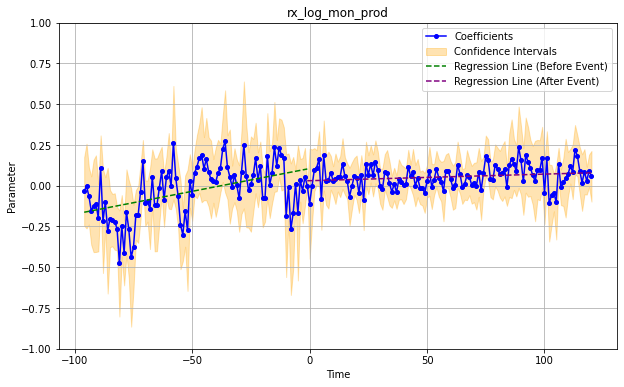

In [119]:
# take log
formula="log_rx_pro_agg ~ "+elasped


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod",title="rx_log_mon_prod",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elasped_m96         0.4570     0.3974     1.1500     0.2503     -0.3223      1.2364
elasped_m95         0.7595     0.3961     1.9174     0.0553     -0.0173      1.5363
elasped_m94         0.0111     0.3950     0.0281     0.9776     -0.7636      0.7858
elasped_m93        -0.4102     0.7705    -0.5323     0.5946     -1.9212      1.1009
elasped_m92         0.2956     0.7070     0.4181     0.6759     -1.0909      1.6820
elasped_m91         0.3927     0.4554     0.8623     0.3886     -0.5003      1.2858
elasped_m90         0.1268     0.3012     0.4210     0.6738     -0.4639      0.7175
elasped_m89         0.2107     0.3559     0.5918     0.5540     -0.4873      0.9087
elasped_m88        -0.1266     0.3942    -0.3213     0.7480     -0.8996     

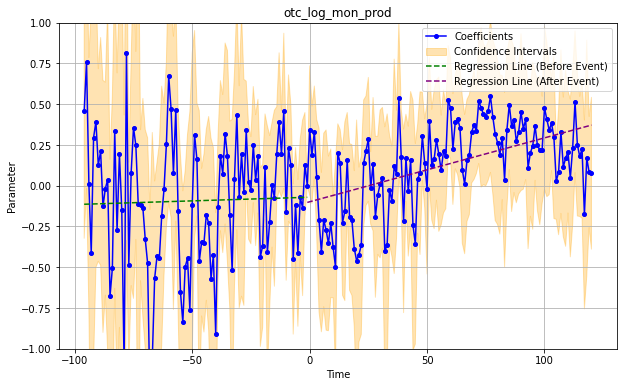

In [120]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elasped


# log_stock_rx_lag
# formula+=" + log_otc_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod",title="otc_log_mon_prod",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)